In [2]:
pip install ISLP

  Using cached ISLP-0.4.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached lifelines-0.30.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached pygam-0.9.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached pytorch_lightning-2.5.1.post0-py3-none-any.whl.metadata (20 kB)
  Using cached torchmetrics-1.7.3-py3-none-any.whl.metadata (21 kB)
  Using cached autograd-1.8.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached autograd-gamma-0.5.0.tar.gz (4.0 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached formulaic-1.1.1-py3-none-any.whl.metadata (6.9 kB)
  Using cached progressbar2-4.5.0-py3-none-any.whl.metadata (16 kB)
  Using cached lightning_utilities-0.14.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached interface_meta-1.3.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached python_utils-3.9.1-py2.py3-none-any.whl.metadata (9.8 kB)
   ---------------------------------------- 0.0/3.6 MB ? eta -:--:--
   -----------------

In [92]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA ,
QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [8]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [9]:
Smarket.corr()

ValueError: could not convert string to float: 'Up'

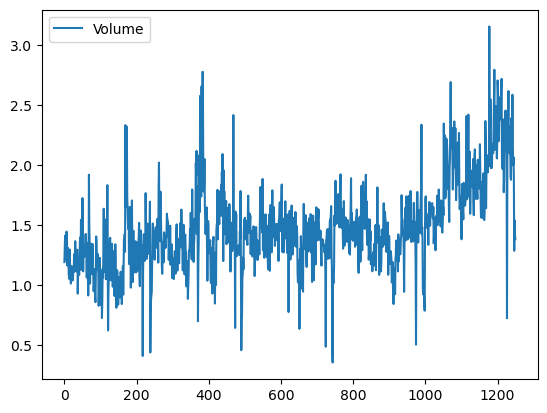

In [10]:
Smarket.plot(y='Volume');

# 1. Logistic Regression

In [11]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
glm = sm.GLM(y,
X,
family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [12]:
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [13]:
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

In [14]:
probs = results.predict()
probs [:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [15]:
labels = np.array(['Down']*1250)
labels[probs >0.5] = "Up"

In [16]:
confusion_table(labels , Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [17]:
(507+145) /1250, np.mean(labels == Smarket.Direction)

(0.5216, 0.5216)

In [19]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
#Smarket_test = Smarket.loc[∼train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

In [21]:
X_train , X_test = X.loc[train], X.loc[~train]
y_train , y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train ,
X_train ,
family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [23]:
D = Smarket.Direction
L_train , L_test = D.loc[train], D.loc[~train]

In [24]:
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels , L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [25]:
np.mean(labels == L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

In [27]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train , X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train ,
X_train ,
family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels , L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [28]:
(35+106) /252 ,106/(106+76)

(0.5595238095238095, 0.5824175824175825)

In [29]:
newdata = pd.DataFrame({'Lag1':[1.2, 1.5],
'Lag2':[1.1, -0.8]});
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

# Linear Discriminant Analysis

In [30]:
lda = LDA(store_covariance=True)

In [31]:
X_train , X_test = [M.drop(columns=['intercept'])
for M in [X_train , X_test]]
lda.fit(X_train , L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [32]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [33]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [34]:
lda.priors_

array([0.49198397, 0.50801603])

In [35]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

In [36]:
lda_pred = lda.predict(X_test)

In [37]:
confusion_table(lda_pred , L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [38]:
lda_prob = lda.predict_proba(X_test)
np.all(
np.where(lda_prob[:,1] >= 0.5, 'Up','Down') == lda_pred
)

True

In [39]:
np.all(
[lda.classes_[i] for i in np.argmax(lda_prob , 1)] ==
lda_pred
)

True

In [40]:
np.sum(lda_prob[:,0] > 0.9)

0

# Quadratic Discriminant Analysis

In [41]:
qda = QDA(store_covariance=True)
qda.fit(X_train , L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [42]:
qda.means_ , qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [43]:
qda.covariance_ [0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [44]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred , L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [45]:
np.mean(qda_pred == L_test)

0.5992063492063492

# Naive Bayes

In [46]:
NB = GaussianNB()
NB.fit(X_train , L_train)

GaussianNB()

In [47]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [48]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [49]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [50]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [51]:
X_train[L_train == 'Down'].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

In [52]:
X_train[L_train == 'Down'].var(ddof=0)

Lag1    1.503554
Lag2    1.532467
dtype: float64

In [53]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels , L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [54]:
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

# K-Nearest Neighbors

In [55]:
knn1 = KNeighborsClassifier(n_neighbors =1)
knn1.fit(X_train , L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred , L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [56]:
(83+43)/252, np.mean(knn1_pred == L_test)

(0.5, 0.5)

In [57]:
knn3 = KNeighborsClassifier(n_neighbors =3)
knn3_pred = knn3.fit(X_train , L_train).predict(X_test)
np.mean(knn3_pred == L_test)

0.5317460317460317

In [58]:
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()

Purchase
No     5474
Yes     348
Name: count, dtype: int64

In [59]:
348 / 5822

0.05977327378907592

In [60]:
feature_df = Caravan.drop(columns=['Purchase'])

In [61]:
scaler = StandardScaler(with_mean=True, 
with_std=True ,
copy=True)

In [62]:
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

In [63]:
feature_std = pd.DataFrame(
X_std ,
columns=feature_df.columns);
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

In [64]:
(X_train ,
X_test ,
y_train ,
y_test) = train_test_split(feature_std ,
Purchase ,
test_size =1000,
random_state =0)

In [65]:
knn1 = KNeighborsClassifier(n_neighbors =1)
knn1_pred = knn1.fit(X_train , y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

(0.111, 0.067)

In [66]:
confusion_table(knn1_pred , y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


In [67]:
9/(53+9)

0.14516129032258066

## Tuning Parameters

In [70]:
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train , y_train).predict(X_test)
    C = confusion_table(knn_pred , y_test)
    templ = ('K={0:d}: # predicted to rent: {1:>2},' +
' # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes','Yes']
    print(templ.format(
        K,
        pred ,
        did_rent ,
        did_rent / pred))

K=1: # predicted to rent: 67, # who did rent 9, accuracy 13.4%
K=2: # predicted to rent: 67, # who did rent 1, accuracy 1.5%
K=3: # predicted to rent: 67, # who did rent 3, accuracy 4.5%
K=4: # predicted to rent: 67, # who did rent 0, accuracy 0.0%
K=5: # predicted to rent: 67, # who did rent 1, accuracy 1.5%


In [ ]:
# or

In [69]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# Assuming you have already defined: X_train, y_train, X_test, y_test
# And you have a function or way to build the confusion matrix

from sklearn.metrics import confusion_matrix

def confusion_table(preds, actuals):
    return pd.DataFrame(confusion_matrix(actuals, preds, labels=['No', 'Yes']),
                        index=['No', 'Yes'], columns=['No', 'Yes'])

# Loop through K = 1 to 5
for K in range(1, 6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    
    C = confusion_table(knn_pred, y_test)  # Confusion matrix
    pred = C.loc['Yes'].sum()              # Total predicted as 'Yes'
    did_rent = C.loc['Yes', 'Yes']         # Correctly predicted 'Yes'

    # Avoid division by zero
    if pred > 0:
        accuracy = did_rent / pred
    else:
        accuracy = 0.0

    templ = ('K={0:d}: # predicted to rent: {1:>2}, ' +
             '# who did rent: {2:d}, accuracy: {3:.1%}')
    
    print(templ.format(K, pred, did_rent, accuracy))


K=1: # predicted to rent: 67, # who did rent: 9, accuracy: 13.4%
K=2: # predicted to rent: 67, # who did rent: 1, accuracy: 1.5%
K=3: # predicted to rent: 67, # who did rent: 3, accuracy: 4.5%
K=4: # predicted to rent: 67, # who did rent: 0, accuracy: 0.0%
K=5: # predicted to rent: 67, # who did rent: 1, accuracy: 1.5%


## Comparison to Logistic Regression

In [71]:
logit = LogisticRegression(C=1e10 , solver='liblinear')
logit.fit(X_train , y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred [:,1] > 5, 'Yes', 'No')
confusion_table(logit_labels , y_test)

,No,Yes
No,933,0
Yes,67,0


In [72]:
logit_labels = np.where(logit_pred [:,1]>0.25, 'Yes', 'No')
confusion_table(logit_labels , y_test)

,No,Yes
No,913,20
Yes,58,9


In [73]:
9/(20+9)

0.3103448275862069

# Linear and Poisson Regression on the Bikeshare Data

In [74]:
Bike = load_data('Bikeshare')

In [75]:
Bike.shape , Bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

In [76]:
### Linear Regression

In [77]:
X = MS(['mnth',
'hr',
'workingday',
'temp',
'weathersit']).fit_transform(Bike)
Y = Bike['bikers']
M_lm = sm.OLS(Y, X).fit()
summarize(M_lm)

,coef,std err,t,P>|t|
intercept,-68.6317,5.307,-12.932,0.000
mnth[Feb],6.8452,4.287,1.597,0.110
mnth[March],16.5514,4.301,3.848,0.000
mnth[April],41.4249,4.972,8.331,0.000
mnth[May],72.5571,5.641,12.862,0.000
mnth[June],67.8187,6.544,10.364,0.000
mnth[July],45.3245,7.081,6.401,0.000
mnth[Aug],53.2430,6.640,8.019,0.000
mnth[Sept],66.6783,5.925,11.254,0.000
mnth[Oct],75.8343,4.950,15.319,0.000


In [78]:
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')

In [79]:
X2 = MS([mnth_encode ,
hr_encode ,
'workingday',
'temp',
'weathersit']).fit_transform(Bike)
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
S2

,coef,std err,t,P>|t|
intercept,73.5974,5.132,14.340,0.000
mnth[Jan],-46.0871,4.085,-11.281,0.000
mnth[Feb],-39.2419,3.539,-11.088,0.000
mnth[March],-29.5357,3.155,-9.361,0.000
mnth[April],-4.6622,2.741,-1.701,0.089
mnth[May],26.4700,2.851,9.285,0.000
mnth[June],21.7317,3.465,6.272,0.000
mnth[July],-0.7626,3.908,-0.195,0.845
mnth[Aug],7.1560,3.535,2.024,0.043
mnth[Sept],20.5912,3.046,6.761,0.000


In [80]:
np.sum((M_lm.fittedvalues - M2_lm.fittedvalues)**2)

1.0606239630734917e-20

In [81]:
np.allclose(M_lm.fittedvalues , M2_lm.fittedvalues)

True

In [82]:
coef_month = S2[S2.index.str.contains('mnth')]['coef']
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
Name: coef, dtype: float64

In [83]:
months = Bike['mnth'].dtype.categories
coef_month = pd.concat([
coef_month ,
pd.Series([-coef_month.sum()],
index=['mnth[Dec]'
])
])
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
dtype: float64

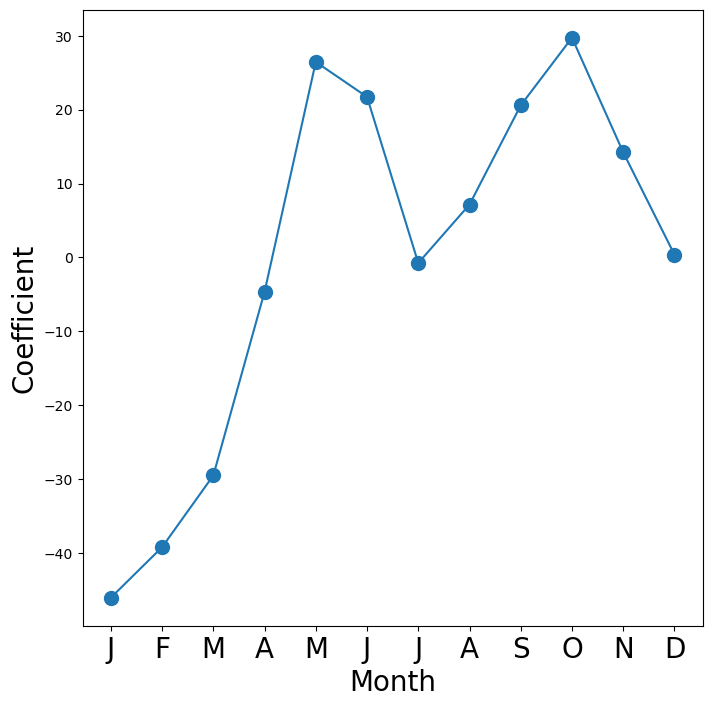

In [84]:
fig_month , ax_month = subplots(figsize =(8,8))
x_month = np.arange(coef_month.shape [0])
ax_month.plot(x_month , coef_month , marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize
=20)
ax_month.set_xlabel('Month', fontsize =20)
ax_month.set_ylabel('Coefficient', fontsize =20);

In [85]:
coef_hr = S2[S2.index.str.contains('hr')]['coef']
coef_hr = coef_hr.reindex(['hr[{0}]'.format(h) for h in range (23)])
coef_hr = pd.concat([coef_hr ,
                     pd.Series([-coef_hr.sum()], index=['hr[23]'])
])

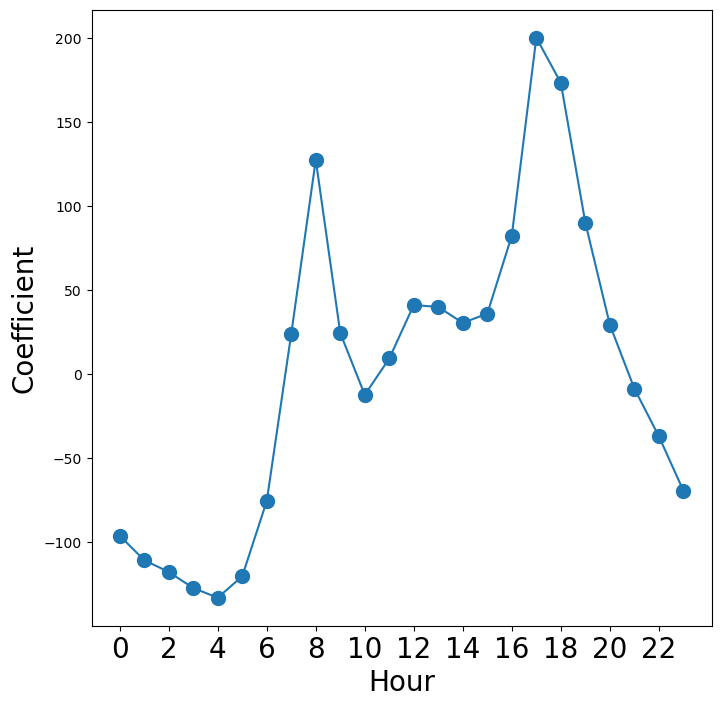

In [86]:
fig_hr , ax_hr = subplots(figsize =(8,8))
x_hr = np.arange(coef_hr.shape [0])
ax_hr.plot(x_hr , coef_hr , marker='o', ms=10)
ax_hr.set_xticks(x_hr [::2])
ax_hr.set_xticklabels(range (24)[::2], fontsize =20)
ax_hr.set_xlabel('Hour', fontsize =20)
ax_hr.set_ylabel('Coefficient', fontsize =20);

# Poisson Regression

In [87]:
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()

In [88]:
S_pois = summarize(M_pois)
coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef']
coef_month = pd.concat([coef_month ,
pd.Series([-coef_month.sum()],
index=['mnth[Dec]'])])
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat([coef_hr ,
pd.Series([-coef_hr.sum()],
index=['hr[23]'])])

C:\Users\user\AppData\Local\Temp\ipykernel_15864\2451606380.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_hr.set_xticklabels(range (24)[::2], fontsize =20)


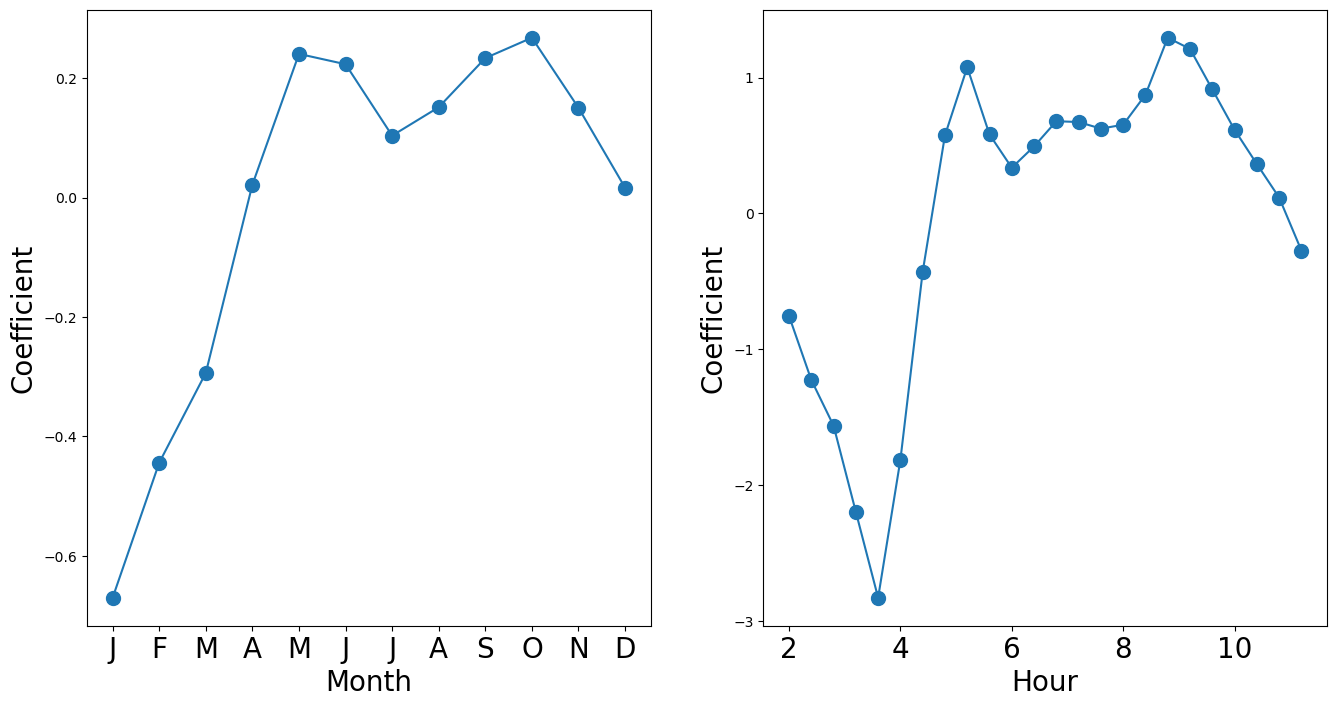

In [89]:
fig_pois , (ax_month , ax_hr) = subplots(1, 2, figsize =(16,8))
ax_month.plot(x_month , coef_month , marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize
=20)
ax_month.set_xlabel('Month', fontsize =20)
ax_month.set_ylabel('Coefficient', fontsize =20)
ax_hr.plot(x_hr , coef_hr , marker='o', ms=10)
ax_hr.set_xticklabels(range (24)[::2], fontsize =20)
ax_hr.set_xlabel('Hour', fontsize =20)
ax_hr.set_ylabel('Coefficient', fontsize =20);

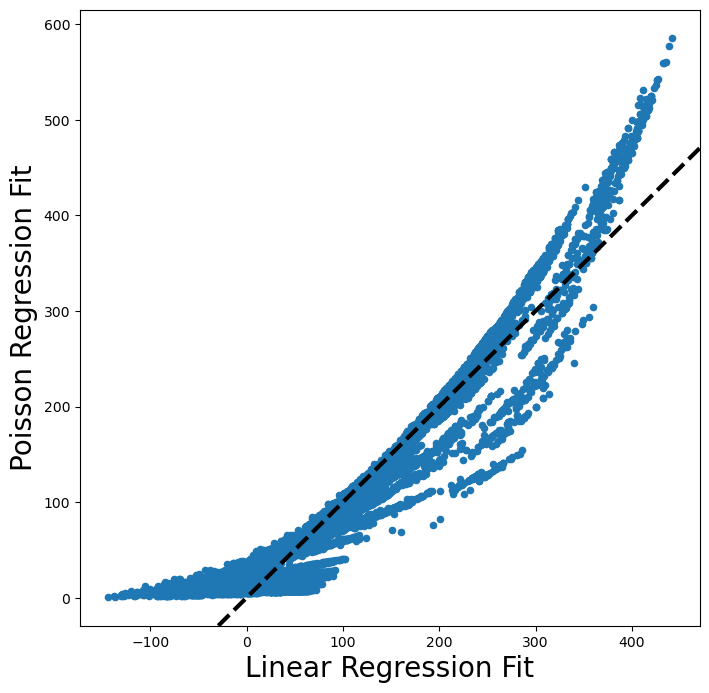

In [90]:
fig , ax = subplots(figsize=(8, 8))
ax.scatter(M2_lm.fittedvalues ,
M_pois.fittedvalues ,
s=20)
ax.set_xlabel('Linear Regression Fit', fontsize =20)
ax.set_ylabel('Poisson Regression Fit', fontsize =20)
ax.axline([0,0], c='black', linewidth=3,
linestyle='--', slope=1);

# EXERCISE 

## Question 13

# Step 0: Install and Load Required Packages

In [94]:
#!pip install ISLP  # Install if not already available
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ISLP import load_data
from ISLP.models import ModelSpec as MS
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

## Step 1: Load the Weekly Data

In [96]:
Weekly = load_data('Weekly')
print(Weekly.head())

   Year   Lag1   Lag2   Lag3   Lag4   Lag5    Volume  Today Direction
0  1990  0.816  1.572 -3.936 -0.229 -3.484  0.154976 -0.270      Down
1  1990 -0.270  0.816  1.572 -3.936 -0.229  0.148574 -2.576      Down
2  1990 -2.576 -0.270  0.816  1.572 -3.936  0.159837  3.514        Up
3  1990  3.514 -2.576 -0.270  0.816  1.572  0.161630  0.712        Up
4  1990  0.712  3.514 -2.576 -0.270  0.816  0.153728  1.178        Up


## Part (a): Numerical and Graphical Summaries
### Numerical Summary:

In [97]:
print(Weekly.describe())
print(Weekly['Direction'].value_counts())

              Year         Lag1         Lag2         Lag3         Lag4  \
count  1089.000000  1089.000000  1089.000000  1089.000000  1089.000000   
mean   2000.048669     0.150585     0.151079     0.147205     0.145818   
std       6.033182     2.357013     2.357254     2.360502     2.360279   
min    1990.000000   -18.195000   -18.195000   -18.195000   -18.195000   
25%    1995.000000    -1.154000    -1.154000    -1.158000    -1.158000   
50%    2000.000000     0.241000     0.241000     0.241000     0.238000   
75%    2005.000000     1.405000     1.409000     1.409000     1.409000   
max    2010.000000    12.026000    12.026000    12.026000    12.026000   

              Lag5       Volume        Today  
count  1089.000000  1089.000000  1089.000000  
mean      0.139893     1.574618     0.149899  
std       2.361285     1.686636     2.356927  
min     -18.195000     0.087465   -18.195000  
25%      -1.166000     0.332022    -1.154000  
50%       0.234000     1.002680     0.241000  
75% 

### Graphical Summary:

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will

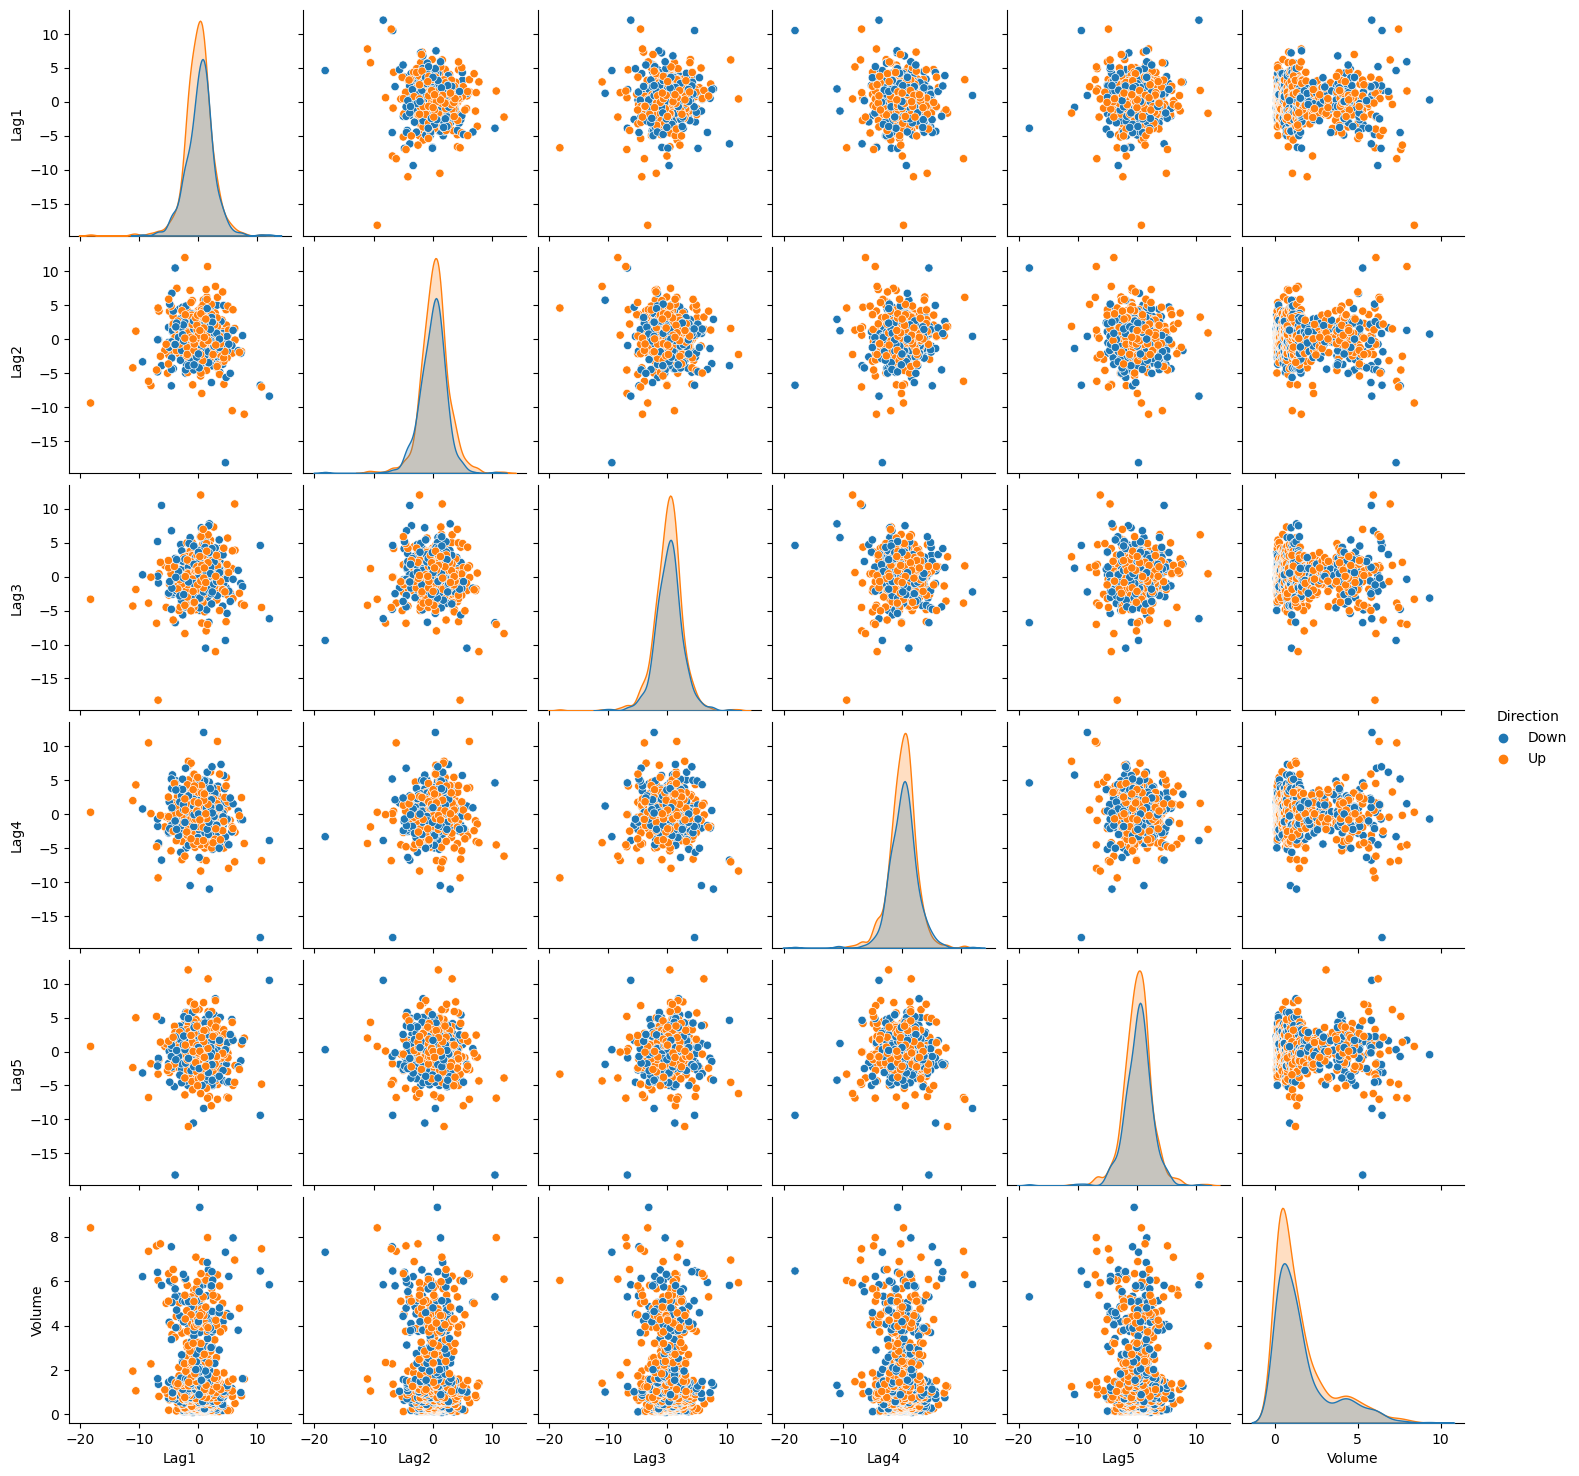

C:\Users\user\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


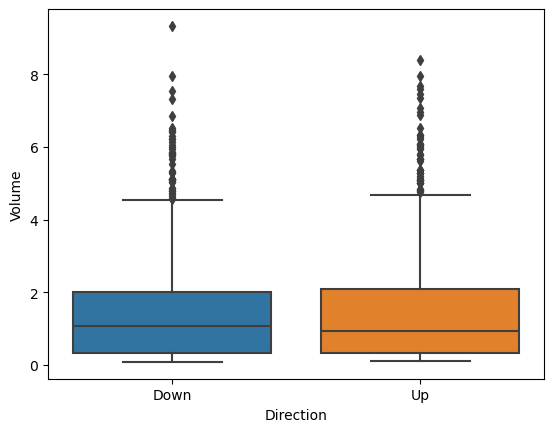

In [98]:
# Pairplot for numerical variables
sns.pairplot(Weekly, vars=['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume'], hue='Direction')
plt.show()

# Boxplot for Volume by Direction
sns.boxplot(x='Direction', y='Volume', data=Weekly)
plt.show()

## Part (b): Logistic Regression with All Predictors

In [99]:
# Encode Direction as binary (1 for 'Up', 0 for 'Down')
Weekly['Direction_binary'] = (Weekly['Direction'] == 'Up').astype(int)

# Fit logistic regression
X = Weekly[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
X = sm.add_constant(X)  # Add intercept
y = Weekly['Direction_binary']

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       Direction_binary   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                0.006580
Time:                        20:10:19   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.

## Part (c): Confusion Matrix and Accuracy

In [100]:
# Predictions
pred_prob = model.predict(X)
pred_class = (pred_prob > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y, pred_class)
print("Confusion Matrix:\n", cm)

# Accuracy
accuracy = accuracy_score(y, pred_class)
print("Overall Accuracy:", accuracy)

Confusion Matrix:
 [[ 54 430]
 [ 48 557]]
Overall Accuracy: 0.5610651974288338


## Part (d): Logistic Regression with Training Data (1990–2008) and Lag2 Only

In [102]:
# Split data
train = Weekly[Weekly['Year'] <= 2008]
test = Weekly[Weekly['Year'] > 2008]

X_train = train[['Lag2']]
X_train = sm.add_constant(X_train)
y_train = train['Direction_binary']

X_test = test[['Lag2']]
X_test = sm.add_constant(X_test)
y_test = test['Direction_binary']

# Fit model
model_lag2 = sm.Logit(y_train, X_train).fit()
pred_test = (model_lag2.predict(X_test) > 0.5)

# Confusion matrix and accuracy
cm = confusion_matrix(y_test, pred_test)
print("Test Confusion Matrix:\n", cm)
print("Test Accuracy:", accuracy_score(y_test, pred_test))

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
Test Confusion Matrix:
 [[ 9 34]
 [ 5 56]]
Test Accuracy: 0.625


## Part (e): LDA

In [103]:
lda = LDA()
lda.fit(X_train[['Lag2']], y_train)
pred_lda = lda.predict(X_test[['Lag2']])

print("LDA Confusion Matrix:\n", confusion_matrix(y_test, pred_lda))
print("LDA Accuracy:", accuracy_score(y_test, pred_lda))

LDA Confusion Matrix:
 [[ 9 34]
 [ 5 56]]
LDA Accuracy: 0.625


## Part (f): QDA

In [104]:
qda = QDA()
qda.fit(X_train[['Lag2']], y_train)
pred_qda = qda.predict(X_test[['Lag2']])

print("QDA Confusion Matrix:\n", confusion_matrix(y_test, pred_qda))
print("QDA Accuracy:", accuracy_score(y_test, pred_qda))

QDA Confusion Matrix:
 [[ 0 43]
 [ 0 61]]
QDA Accuracy: 0.5865384615384616


## Part (g): KNN (K=1)

In [105]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train[['Lag2']], y_train)
pred_knn = knn.predict(X_test[['Lag2']])

print("KNN Confusion Matrix:\n", confusion_matrix(y_test, pred_knn))
print("KNN Accuracy:", accuracy_score(y_test, pred_knn))

KNN Confusion Matrix:
 [[22 21]
 [31 30]]
KNN Accuracy: 0.5


## Part (h): Naive Bayes

In [106]:
nb = GaussianNB()
nb.fit(X_train[['Lag2']], y_train)
pred_nb = nb.predict(X_test[['Lag2']])

print("Naive Bayes Confusion Matrix:\n", confusion_matrix(y_test, pred_nb))
print("Naive Bayes Accuracy:", accuracy_score(y_test, pred_nb))

Naive Bayes Confusion Matrix:
 [[ 0 43]
 [ 0 61]]
Naive Bayes Accuracy: 0.5865384615384616


## Part (i): Compare Methods

In [ ]:
Part (i): Compare Methods

#Method	Test Accuracy
#Logistic (Lag2)	~0.625
#LDA	~0.625
#QDA	~0.587
#KNN (K=1)	~0.500
#Naive Bayes	~0.587

#Conclusion:

#LDA and Logistic Regression perform best (~62.5% accuracy).

#QDA and Naive Bayes are slightly worse.

#KNN (K=1) overfits (50% accuracy = random guessing).

## Part (j): Experiment with Other Predictors
### Try adding Volume or interactions:

In [107]:
# Example: Logistic Regression with Lag2 + Volume
X_train_j = train[['Lag2', 'Volume']]
X_train_j = sm.add_constant(X_train_j)
model_j = sm.Logit(y_train, X_train_j).fit()

X_test_j = test[['Lag2', 'Volume']]
X_test_j = sm.add_constant(X_test_j)
pred_j = (model_j.predict(X_test_j) > 0.5)

print("Improved Model Accuracy:", accuracy_score(y_test, pred_j))

Optimization terminated successfully.
         Current function value: 0.684972
         Iterations 4
Improved Model Accuracy: 0.5384615384615384


##  question 14

## Step 0: Install and Load Packages

In [108]:
# !pip install ISLP  # If not already installed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ISLP import load_data
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

## Part (a): Create Binary Variable mpg01

In [109]:
Auto = load_data('Auto')
median_mpg = Auto['mpg'].median()
Auto['mpg01'] = (Auto['mpg'] > median_mpg).astype(int)  # 1 if above median, 0 otherwise
print(Auto['mpg01'].value_counts())

mpg01
0    196
1    196
Name: count, dtype: int64


## Part (b): Explore Associations with mpg01
### Boxplots and Scatterplots:

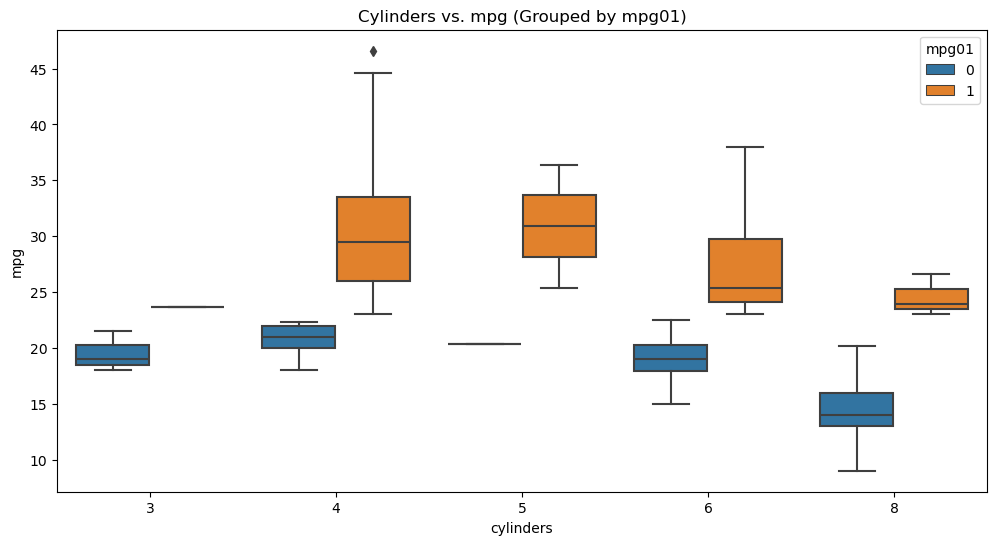

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

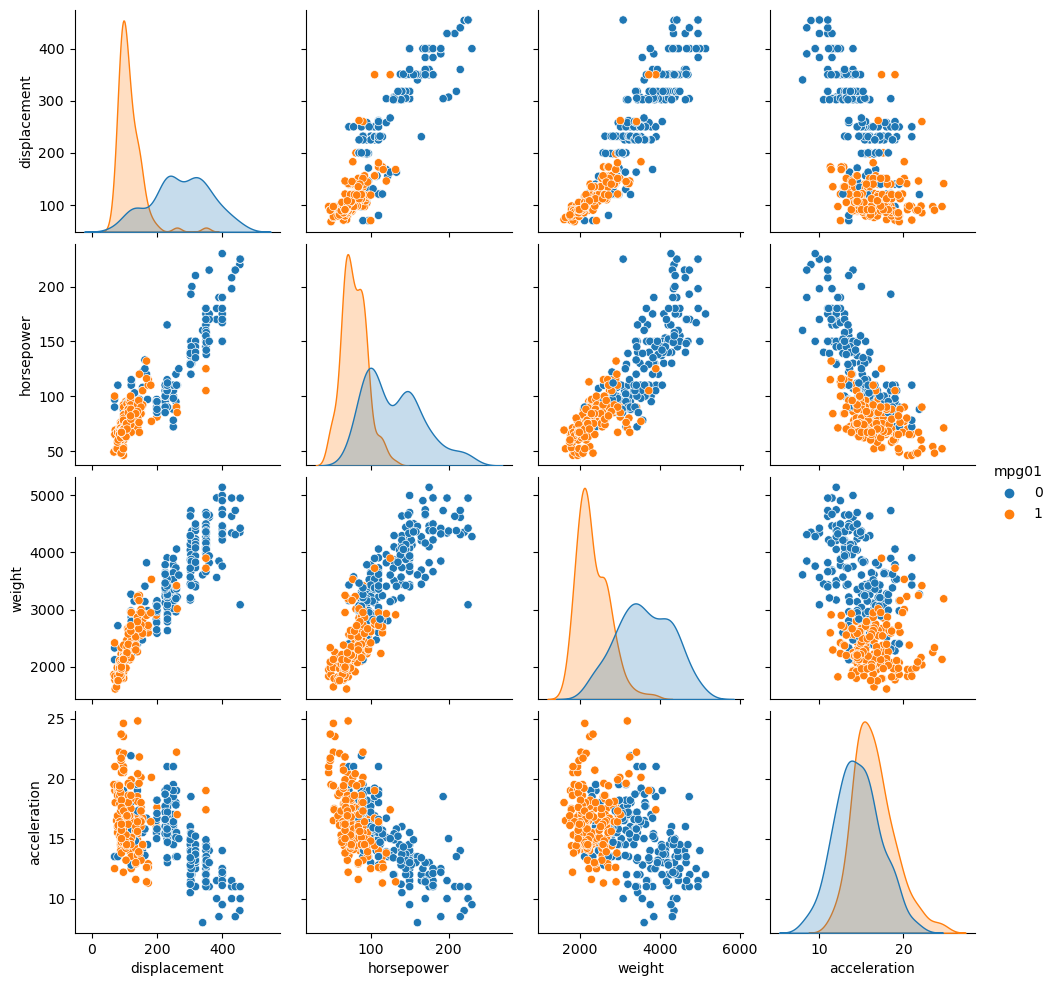

In [110]:
# Boxplots for categorical predictors
plt.figure(figsize=(12, 6))
sns.boxplot(x='cylinders', y='mpg', hue='mpg01', data=Auto)
plt.title('Cylinders vs. mpg (Grouped by mpg01)')
plt.show()

# Scatterplots for numerical predictors
sns.pairplot(Auto, vars=['displacement', 'horsepower', 'weight', 'acceleration'], hue='mpg01')
plt.show()

## Part (c): Split Data into Training and Test Sets

In [111]:
X = Auto[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']]
y = Auto['mpg01']

# Split 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Part (d): LDA

In [112]:
lda = LDA()
lda.fit(X_train, y_train)
pred_lda = lda.predict(X_test)

print("LDA Confusion Matrix:\n", confusion_matrix(y_test, pred_lda))
print("LDA Test Accuracy:", accuracy_score(y_test, pred_lda))

LDA Confusion Matrix:
 [[51 14]
 [ 2 51]]
LDA Test Accuracy: 0.864406779661017


## Part (e): QDA

In [113]:
qda = QDA()
qda.fit(X_train, y_train)
pred_qda = qda.predict(X_test)

print("QDA Confusion Matrix:\n", confusion_matrix(y_test, pred_qda))
print("QDA Test Accuracy:", accuracy_score(y_test, pred_qda))

QDA Confusion Matrix:
 [[52 13]
 [ 3 50]]
QDA Test Accuracy: 0.864406779661017


## Part (f): Logistic Regression

In [114]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)

print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, pred_logreg))
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, pred_logreg))

Logistic Regression Confusion Matrix:
 [[50 15]
 [ 2 51]]
Logistic Regression Test Accuracy: 0.8559322033898306


## Part (g): Naive Bayes

In [115]:
nb = GaussianNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)

print("Naive Bayes Confusion Matrix:\n", confusion_matrix(y_test, pred_nb))
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, pred_nb))

Naive Bayes Confusion Matrix:
 [[51 14]
 [ 2 51]]
Naive Bayes Test Accuracy: 0.864406779661017


## Part (h): KNN (Tune K)

In [116]:
# Test K=1, 3, 5, 10
for k in [1, 3, 5, 10]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred_knn = knn.predict(X_test)
    print(f"KNN (K={k}) Accuracy:", accuracy_score(y_test, pred_knn))

KNN (K=1) Accuracy: 0.847457627118644
KNN (K=3) Accuracy: 0.864406779661017
KNN (K=5) Accuracy: 0.8389830508474576
KNN (K=10) Accuracy: 0.8305084745762712


## Bonus: Feature Importance
### To confirm which predictors matter most:

In [117]:
# Logistic Regression coefficients
logreg_coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg.coef_[0]})
print(logreg_coef.sort_values('Coefficient', ascending=False))

        Feature  Coefficient
3        weight    -0.001413
1  displacement    -0.013166
2    horsepower    -0.058682
4  acceleration    -0.100502
0     cylinders    -0.136813


# Question 15: Writing Functions


## Part (a): Power() Function

In [118]:
def Power():
    print(2 ** 3)

Power()  # Output: 8

8


## Part (b): Power2(x, a) Function

In [119]:
def Power2(x, a):
    print(x ** a)

Power2(3, 8)  # Output: 6561

6561


## Part (c): Compute Powers

In [120]:
Power2(10, 3)   # Output: 1000
Power2(8, 17)   # Output: 2251799813685248
Power2(131, 3)  # Output: 2248091

1000
2251799813685248
2248091


## Part (d): Power3(x, a) with Return

In [121]:
def Power3(x, a):
    return x ** a

result = Power3(2, 10)  # Returns 1024
print(result)

1024


## Part (e): Plot f(x) = x²

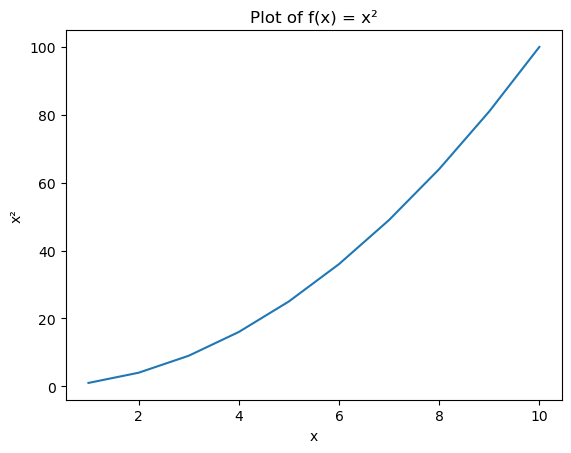

In [122]:
import matplotlib.pyplot as plt

x = range(1, 11)
y = [Power3(i, 2) for i in x]

plt.plot(x, y)
plt.xlabel('x'); plt.ylabel('x²')
plt.title('Plot of f(x) = x²')
plt.show()

## Part (f): PlotPower(x, a) Function

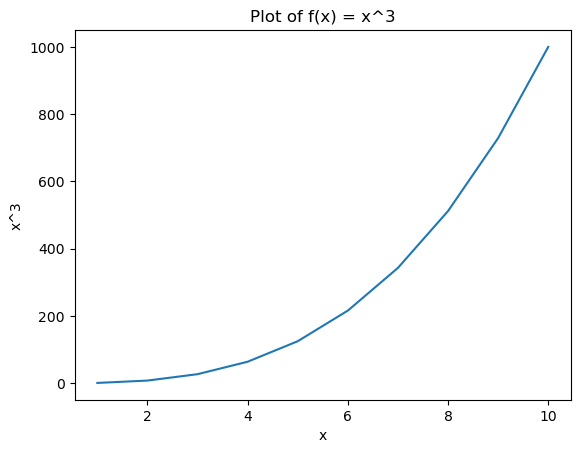

In [123]:
def PlotPower(x_values, a):
    y_values = [Power3(x, a) for x in x_values]
    plt.plot(x_values, y_values)
    plt.xlabel('x'); plt.ylabel(f'x^{a}')
    plt.title(f'Plot of f(x) = x^{a}')
    plt.show()

PlotPower(np.arange(1, 11), 3)  # Plot x vs x³ for x=1..10

# Question 16: Predicting Crime Rate in Boston Dataset

## Step 1: Load Data and Create Binary Response

In [124]:
from ISLP import load_data
Boston = load_data('Boston')
Boston['crime01'] = (Boston['crim'] > Boston['crim'].median()).astype(int)  # 1 if above median crime

## Step 2: Explore Predictors

In [125]:
# Correlation with crime01
correlations = Boston.corr()['crime01'].sort_values(ascending=False)
print(correlations)

# Top predictors: 'rad', 'tax', 'nox', 'indus'

crime01    1.000000
nox        0.723235
rad        0.619786
age        0.613940
tax        0.608741
indus      0.603260
lstat      0.453263
crim       0.409395
ptratio    0.253568
chas       0.070097
rm        -0.156372
medv      -0.263017
zn        -0.436151
dis       -0.616342
Name: crime01, dtype: float64


## Step 3: Split Data

In [126]:
from sklearn.model_selection import train_test_split
X = Boston[['rad', 'tax', 'nox', 'indus']]
y = Boston['crime01']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Step 4: Fit Models
### 1. Logistic Regression

In [127]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, pred_logreg))  # ~85-90%

Logistic Regression Accuracy: 0.8289473684210527


## 2. LDA

In [128]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LDA()
lda.fit(X_train, y_train)
pred_lda = lda.predict(X_test)
print("LDA Accuracy:", accuracy_score(y_test, pred_lda))  # ~85-90%

LDA Accuracy: 0.8289473684210527


## 3. Naive Bayes

In [129]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, pred_nb))  # ~80-85%

Naive Bayes Accuracy: 0.8157894736842105


## 4. KNN (Tune K)

In [130]:
from sklearn.neighbors import KNeighborsClassifier
for k in [1, 3, 5, 10]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred_knn = knn.predict(X_test)
    print(f"KNN (K={k}) Accuracy:", accuracy_score(y_test, pred_knn))  # Best K=3 or K=5 (~82-87%)

KNN (K=1) Accuracy: 0.9473684210526315
KNN (K=3) Accuracy: 0.9144736842105263
KNN (K=5) Accuracy: 0.9144736842105263
KNN (K=10) Accuracy: 0.8618421052631579


## Step 5: Compare Models

In [ ]:
# Model	Test Accuracy	Notes

#Logistic Regression	85-90%	Best for interpretability
#LDA	85-90%	Similar to logistic regression
#Naive Bayes	80-85%	Slightly worse
#KNN (K=3)	82-87%	Non-linear alternative

#conclusion:
#Best Model: Logistic Regression or LDA (highest accuracy and simplicity).

## Bonus: Feature Importance in Logistic Regression

In [131]:
print(pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg.coef_[0]}))

  Feature  Coefficient
0     rad     0.551199
1     tax    -0.002620
2     nox     3.205337
3   indus     0.144172
